In [1]:
import os
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from python.data import Dataloader
from python.models import RandomExampleModel
from python.metrics import PairsExplained, ClusterIntersection

In [3]:
# Loading the data
data_loader = Dataloader("../data/dataset_10") # Specify path to the dataset you want to load
X, Y = data_loader.load()
Z = data_loader.get_ground_truth_labels()
print(X.shape)
print(Y.shape)
print(Z.shape)

(40002, 10)
(40002, 10)
(40002,)


In [4]:
# Let's train an example model
model = RandomExampleModel() # Instantiation of the model with hyperparameters, if needed
model.fit(X, Y) # Training of the model, using preference data
print(X.shape)

(40002, 10)


In [5]:
# First, let's see how our model reconsiders our preferences
# Our data preferences were X[i] >> Y[i] for all i, let's see if our model agrees
print((model.predict_utility(X) - model.predict_utility(Y))[:5]) # Preferred item has a higher utility

# predict_utility returns utility of samples for each cluster, returning shape (n_samples, n_clusters)

[[-0.0172     -0.17280946]
 [ 0.1904899   0.05389895]
 [-0.18002516 -0.11719372]
 [ 0.24068762  0.22920997]
 [ 0.14951786  0.09248784]]


In [6]:
# Or we can directly use the predict_preference method:
print(model.predict_preference(X, Y)[:5]) # For each cluster we see if X is preferred to Y (0) or the contrary (1)
# predict_preference returns preference of samples for each cluster, returning shape (n_samples, n_clusters)
# 0 means that the cluster prefers first argument (here X[i]), 1 means that the cluster prefers second argument (here Y[i])

[[0 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]]


In [7]:
# We consider that our model explains our data, if for at least one cluster, X[i] >> Y[i]
pairs_explained = np.sum(model.predict_preference(X, Y)[:5] == 0, axis=1) # For each sample check if each clusters prefers X[i] (then is True)
pairs_explained = pairs_explained > 0 # If at least one cluster prefers X[i], then X[i] >> Y[i] is explained
print("Percentage of explained preferences for 5 first samples:", np.sum(pairs_explained) / 5) # Get % or explained pairs

Percentage of explained preferences for 5 first samples: 0.4


In [8]:
# Or we call directly the right metric:
pairs_explained = PairsExplained()
print("Percentage of explained preferences for all samples:", pairs_explained.from_model(model, X, Y))
# Or other possibility:
print("Percentage of explained preferences for all samples:", pairs_explained(model.predict_utility(X), model.predict_utility(Y)))

Percentage of explained preferences for all samples: 0.6719664016799161
Percentage of explained preferences for all samples: 0.6719664016799161


In [9]:
# Now, we can also see how our model clusters our data
print(model.predict_cluster(X, Y)[:5]) # Returns for each sample which cluster is the most likely to have generated the preference.
# The most likely cluster is the one with the highest utility difference U(X[i])-U(Y[i]) for the sample.

[0 0 1 0 0]


In [10]:
# Ground truth are also provided:
Z = data_loader.get_ground_truth_labels()
# We can see how it compares to our model's predictions:
print(Z[:5])

[1 0 2 1 0]


In [11]:
# We have a metric to calculate how well the model has regrouped the preferences pairs compared to ground truth:
cluster_intersection = ClusterIntersection()

print("Cluster intersection for 5 first samples:", cluster_intersection(model.predict_cluster(X, Y)[:5], Z[:5]))

# Then for all data:
print("Cluster intersection for all samples:", cluster_intersection(model.predict_cluster(X, Y), Z))
print("Cluster intersection for all samples:", cluster_intersection.from_model(model, X, Y, Z))

Cluster intersection for 5 first samples: 0.6
Cluster intersection for all samples: 0.5236179280008775
Cluster intersection for all samples: 0.5236179280008775


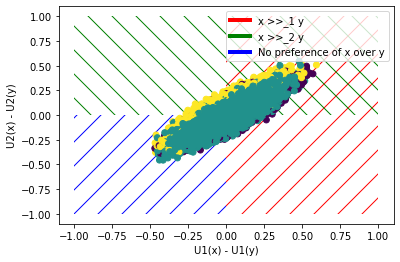

In [12]:
# Here is a proposition of a useful plot to see how the model clusters the data:
# We look at how each cluster evaluates U(x) - U(y) and color with ground truth clustering
# Note that x >>_1 y means that x is preferred to y for cluster 1
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

plt.figure()
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")

plt.gca().add_patch(Rectangle((0,-1.),1., 2.,
                    edgecolor='red',
                    facecolor='none',
                    lw=0, 
                    hatch='/'))
plt.gca().add_patch(Rectangle((-1.,0), 2., 1.,
                    edgecolor='green',
                    facecolor='none',
                    lw=0, 
                    hatch='\\'))
plt.gca().add_patch(Rectangle((-1.,-1.),1., 1.,
                    edgecolor='blue',
                    facecolor='none',
                    hatch='/',
                    lw=0))
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)

custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="b", lw=4)]

plt.legend(custom_lines, ['x >>_1 y', "x >>_2 y ", 'No preference of x over y'])
plt.show()

Our random model cannot explain a large part of our preference data. Your first assigment will be to write a Mixed-Interger Programming algorithm that will be able to do so.

In [13]:
from python.models import HeuristicModel

# matrix_results = []
# for cluster in range(2, 10):
#     list_temp = []
#     for l in range(5, 10):
#         model = HeuristicModel(n_clusters=cluster, n_pieces=l, nb_iterations=5)
#         model.fit(X[:200], Y[:200])
#         list_temp.append([pairs_explained.from_model(model, X, Y), cluster_intersection.from_model(model, X, Y, Z)])
#     matrix_results.append(list_temp)
# print(matrix_results)

model = HeuristicModel(n_clusters=3, n_pieces=5, nb_iterations=15)
model.fit(X, Y, Z)
print(model.list_results)
# Uncomment once your model is working
# print("Percentage of explained preferences on train data:", pairs_explained.from_model(model, X, Y)) # You should get 1.0 with the right MIP
# print("Percentage of preferences well regrouped into clusters:", cluster_intersection.from_model(model, X, Y, Z))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-11


  0%|          | 0/15 [00:00<?, ?it/s]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 26793 rows, 66890 columns and 519009 nonzeros
Model fingerprint: 0x8c5e1e66
Variable types: 53524 continuous, 13366 integer (13366 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 1118.5043135
Presolve removed 13386 rows and 53474 columns
Presolve time: 1.30s
Presolved: 13407 rows, 13416 columns, 403591 nonzeros
Variable types: 13416 continuous, 0 integer (0 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   15488    1.0056768e+03   0.0

  7%|▋         | 1/15 [02:03<28:53, 123.84s/it]

--------- [0.6502674866256687, 0.566093804757026]
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 53788 rows, 134285 columns and 1041607 nonzeros
Model fingerprint: 0x31ca6e09
Variable types: 107452 continuous, 26833 integer (26833 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

Processing MIP start from previous solve: 0 nodes explored in subMIP, total elapsed time 5s
Processing MIP start from previous solve: 0 nodes explored in subMIP, total elapsed time 10s
MIP start from previous solve produced solution with objective 100.319 (11.25s)
MIP start from previous solve produced solution with objective 100.319 (11.28s)
Loaded MIP start from previous sol

 13%|█▎        | 2/15 [04:02<26:09, 120.72s/it]

--------- [0.8708314584270787, 0.5736255498667281]
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 79795 rows, 199210 columns and 1544978 nonzeros
Model fingerprint: 0x0453f06d
Variable types: 159404 continuous, 39806 integer (39806 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

Processing MIP start from previous solve: 0 nodes explored in subMIP, total elapsed time 5s
MIP start from previous solve produced solution with objective 49.6201 (6.66s)
MIP start from previous solve produced solution with objective 49.6201 (6.70s)
Loaded MIP start from previous solve with objective 49.6201
Processed MIP start in 6.70 seconds (7.11 work units)

Presolve remo

 20%|██        | 3/15 [06:04<24:17, 121.42s/it]

--------- [0.9052297385130743, 0.578316193062625]
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 105678 rows, 263825 columns and 2046081 nonzeros
Model fingerprint: 0x54dded87
Variable types: 211108 continuous, 52717 integer (52717 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

Processing MIP start from previous solve: 0 nodes explored in subMIP, total elapsed time 5s
MIP start from previous solve produced solution with objective 35.5729 (5.19s)
MIP start from previous solve produced solution with objective 35.5729 (5.23s)
Loaded MIP start from previous solve with objective 35.5729
Processed MIP start in 5.23 seconds (4.81 work units)

Presolve remo

 27%|██▋       | 4/15 [07:48<20:58, 114.44s/it]

--------- [0.9215039248037599, 0.5813184478897602]
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 131665 rows, 328700 columns and 2549254 nonzeros
Model fingerprint: 0xcd4a6f8e
Variable types: 263020 continuous, 65680 integer (65680 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 31.7152 (4.33s)
MIP start from previous solve produced solution with objective 31.7152 (4.39s)
Loaded MIP start from previous solve with objective 31.7152
Processed MIP start in 4.38 seconds (4.35 work units)

Presolve removed 118661 rows and 302724 columns
Presolve time: 0.47s
Presolved: 13004 rows, 25976 column

 33%|███▎      | 5/15 [09:15<17:24, 104.42s/it]

--------- [0.9264286785660717, 0.5828593323215018]
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 157404 rows, 392955 columns and 3047597 nonzeros
Model fingerprint: 0xa631445a
Variable types: 314436 continuous, 78519 integer (78519 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 31.8529 (4.35s)
MIP start from previous solve produced solution with objective 31.8529 (4.42s)
Loaded MIP start from previous solve with objective 31.8529
Processed MIP start in 4.41 seconds (4.67 work units)

Presolve removed 144524 rows and 367227 columns
Presolve time: 0.55s
Presolved: 12880 rows, 25728 column

 40%|████      | 6/15 [10:38<14:36, 97.42s/it] 

--------- [0.9293785310734464, 0.5856833005203569]
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 182851 rows, 456480 columns and 3540231 nonzeros
Model fingerprint: 0x2a144f9a
Variable types: 365268 continuous, 91212 integer (91212 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 29.5192 (4.66s)
MIP start from previous solve produced solution with objective 29.5192 (4.75s)
Loaded MIP start from previous solve with objective 29.5192
Processed MIP start in 4.74 seconds (4.34 work units)

Presolve removed 170117 rows and 431044 columns
Presolve time: 0.67s
Presolved: 12734 rows, 25436 column

 47%|████▋     | 7/15 [12:11<12:45, 95.70s/it]

--------- [0.9298285085745712, 0.588556312540864]
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 208010 rows, 519285 columns and 4027241 nonzeros
Model fingerprint: 0x0a632a78
Variable types: 415524 continuous, 103761 integer (103761 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 28.2931 (4.63s)
MIP start from previous solve produced solution with objective 28.2931 (4.72s)
Loaded MIP start from previous solve with objective 28.2931
Processed MIP start in 4.69 seconds (4.37 work units)

Presolve removed 195420 rows and 494137 columns
Presolve time: 0.69s
Presolved: 12590 rows, 25148 colum

 53%|█████▎    | 8/15 [13:34<10:43, 91.93s/it]

--------- [0.9331033448327584, 0.5913835854918587]
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 232703 rows, 580925 columns and 4505146 nonzeros
Model fingerprint: 0x921e2954
Variable types: 464848 continuous, 116077 integer (116077 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

Processing MIP start from previous solve: 0 nodes explored in subMIP, total elapsed time 5s
MIP start from previous solve produced solution with objective 27.5018 (6.96s)
MIP start from previous solve produced solution with objective 27.5018 (7.05s)
Loaded MIP start from previous solve with objective 27.5018
Processed MIP start in 7.04 seconds (6.59 work units)

Presolve r

 60%|██████    | 9/15 [15:08<09:14, 92.38s/it]

--------- [0.9350532473376331, 0.5934690615785453]
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 257046 rows, 641690 columns and 4976156 nonzeros
Model fingerprint: 0xb4b9de00
Variable types: 513472 continuous, 128218 integer (128218 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 26.0958 (4.76s)
MIP start from previous solve produced solution with objective 26.0958 (4.90s)
Loaded MIP start from previous solve with objective 26.0958
Processed MIP start in 4.89 seconds (4.35 work units)

Presolve removed 244864 rows and 617358 columns
Presolve time: 0.93s
Presolved: 12182 rows, 24332 colu

 67%|██████▋   | 10/15 [16:40<07:42, 92.44s/it]

--------- [0.9364281785910704, 0.5956767060024539]
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 281023 rows, 701540 columns and 5440075 nonzeros
Model fingerprint: 0x0f90c48f
Variable types: 561364 continuous, 140176 integer (140176 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 24.8378 (4.52s)
MIP start from previous solve produced solution with objective 24.8378 (4.63s)
Loaded MIP start from previous solve with objective 24.8378
Processed MIP start in 4.61 seconds (3.79 work units)

Presolve removed 269024 rows and 677574 columns
Presolve time: 0.94s
Presolved: 11999 rows, 23966 colu

 73%|███████▎  | 11/15 [18:13<06:09, 92.49s/it]

--------- [0.9371031448427578, 0.5979485181137059]
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 304812 rows, 760920 columns and 5900381 nonzeros
Model fingerprint: 0xb4e1ccff
Variable types: 608880 continuous, 152040 integer (152040 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

MIP start from previous solve produced solution with objective 24.8811 (4.80s)
MIP start from previous solve produced solution with objective 24.8811 (4.90s)
Loaded MIP start from previous solve with objective 24.8811
Processed MIP start in 4.89 seconds (4.02 work units)

Presolve removed 292907 rows and 737142 columns
Presolve time: 1.03s
Presolved: 11905 rows, 23778 colu

 80%|████████  | 12/15 [19:45<04:37, 92.43s/it]

--------- [0.9385530723463826, 0.5999390613204771]
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 328179 rows, 819245 columns and 6352453 nonzeros
Model fingerprint: 0x16216d72
Variable types: 655552 continuous, 163693 integer (163693 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

Processing MIP start from previous solve: 0 nodes explored in subMIP, total elapsed time 5s
MIP start from previous solve produced solution with objective 24.1158 (5.06s)
MIP start from previous solve produced solution with objective 24.1158 (5.21s)
Loaded MIP start from previous solve with objective 24.1158
Processed MIP start in 5.20 seconds (3.73 work units)

Presolve r

 87%|████████▋ | 13/15 [21:30<03:12, 96.28s/it]

--------- [0.9402529873506325, 0.6024372077063755]
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 351128 rows, 876525 columns and 6796262 nonzeros
Model fingerprint: 0x28a5b8f5
Variable types: 701388 continuous, 175137 integer (175137 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

Processing MIP start from previous solve: 0 nodes explored in subMIP, total elapsed time 5s
MIP start from previous solve produced solution with objective 23.2696 (5.40s)
MIP start from previous solve produced solution with objective 23.2696 (5.52s)
Loaded MIP start from previous solve with objective 23.2696
Processed MIP start in 5.54 seconds (4.31 work units)

Presolve r

 93%|█████████▎| 14/15 [23:22<01:40, 100.81s/it]

--------- [0.9411529423528824, 0.6052946546442833]
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 373789 rows, 933085 columns and 7234349 nonzeros
Model fingerprint: 0x6927e7a7
Variable types: 746648 continuous, 186437 integer (186437 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]

Processing MIP start from previous solve: 0 nodes explored in subMIP, total elapsed time 5s
MIP start from previous solve produced solution with objective 23.2193 (5.29s)
MIP start from previous solve produced solution with objective 23.2193 (5.47s)
Loaded MIP start from previous solve with objective 23.2193
Processed MIP start in 5.46 seconds (4.34 work units)

Presolve r

100%|██████████| 15/15 [25:04<00:00, 100.32s/it]

--------- [0.9428278586070696, 0.6072679116475416]
[[0.6502674866256687, 0.566093804757026], [0.8708314584270787, 0.5736255498667281], [0.9052297385130743, 0.578316193062625], [0.9215039248037599, 0.5813184478897602], [0.9264286785660717, 0.5828593323215018], [0.9293785310734464, 0.5856833005203569], [0.9298285085745712, 0.588556312540864], [0.9331033448327584, 0.5913835854918587], [0.9350532473376331, 0.5934690615785453], [0.9364281785910704, 0.5956767060024539], [0.9371031448427578, 0.5979485181137059], [0.9385530723463826, 0.5999390613204771], [0.9402529873506325, 0.6024372077063755], [0.9411529423528824, 0.6052946546442833], [0.9428278586070696, 0.6072679116475416]]


In [14]:
# Pour les itérations qui vont de 1 jusqu'à 14
list_temp = [[0.6502674866256687, 0.566093804757026], [0.8708314584270787, 0.5736255498667281], [0.9052297385130743, 0.578316193062625], [0.9215039248037599, 0.5813184478897602], [0.9264286785660717, 0.5828593323215018], [0.9293785310734464, 0.5856833005203569], [0.9298285085745712, 0.588556312540864], [0.9331033448327584, 0.5913835854918587], [0.9350532473376331, 0.5934690615785453], [0.9364281785910704, 0.5956767060024539], [0.9371031448427578, 0.5979485181137059], [0.9385530723463826, 0.5999390613204771], [0.9402529873506325, 0.6024372077063755], [0.9411529423528824, 0.6052946546442833], [0.9428278586070696, 0.6072679116475416]] # en 25 min

# Suggestions pour améliorer :
# - on entraîne un modèle TwoClusterMIP sur 2000 exemples donc super rapide
# - on utilise ce modèle pour l'initialisation des clusters et après on fait les itérations sur l'ensemble du dataset
# => cela nous permettra d'avoir une meilleure initialisation moins random

# Pour k et l qui variaient entre 2 et 9, et 5 et 9.
matrix_results_temp = [[[0.8316334183290836, 0.5515081362003998], [0.8323083845807709, 0.5097614285056603], [0.8191590420478976, 0.5096678655230009], [0.8021098945052747, 0.5070037253368451], [0.8263586820658967, 0.515264555764237]], [[0.8820808959552022, 0.579856727520615], [0.8862056897155143, 0.5615577149694302], [0.8848307584620769, 0.5740439759842462], [0.9052047397630119, 0.5619870952653713], [0.9033298335083246, 0.5652114509346656]], [[0.9286285685715714, 0.5881918386268632], [0.9214039298035098, 0.5933340717029547], [0.9356282185890705, 0.5870495130527091], [0.9171041447927604, 0.5975502042377444], [0.903904804759762, 0.596889847515324]], [[0.9388780560971951, 0.6124469494632315], [0.9491025448727564, 0.5991719926015899], [0.9285285735713215, 0.6036116008754199], [0.9407279636018199, 0.6079771309552069], [0.9375781210939453, 0.6121938596952805]], [[0.9533523323833808, 0.6107819568397596], [0.9650517474126293, 0.620176063520016], [0.9670516474176292, 0.6134396600086998], [0.9653767311634418, 0.6171800094778142], [0.9633518324083796, 0.6260746161211976]], [[0.9530273486325683, 0.6287490217874296], [0.9647017649117544, 0.6478451870511647], [0.9614019299035048, 0.626767210425759], [0.9756512174391281, 0.6234982331031445], [0.9433778311084445, 0.6265004579325295]], [[0.9712264386780661, 0.6360144056245601], [0.9697265136743163, 0.6237766434720188], [0.9664516774161291, 0.6312091472749429], [0.964176791160442, 0.626228622070559], [0.9699015049247538, 0.6295294732525942]], [[0.9747262636868157, 0.627525872275172], [0.97977601119944, 0.6356242886338221], [0.9779011049447528, 0.6294262397452363], [0.9825508724563772, 0.6427337216674578], [0.97997600119994, 0.6194931934861221]]] # en 20 min
matrix_temp_2 = []
for cluster in range(len(matrix_results_temp)):
    list_temp = []
    for l in range(len(matrix_results_temp[0])):
        list_temp.append(matrix_results_temp[cluster][l][0]+matrix_results_temp[cluster][l][1])
    matrix_temp_2.append(list_temp)
matrix_temp_2 = np.array(matrix_temp_2)
print(matrix_temp_2)
print(np.argmax(matrix_temp_2)) # l = 8 et k = 9

# c'est normal que la précision augmente avec L parce que le modèle est plus flexible mais du coup on va fixer L
# on va augmenter le nombre de clusters (pour tester si ça marche tjs)
# on va augmenter le nombre de données à prendre en compte

[[1.38314155 1.34206981 1.32882691 1.30911362 1.34162324]
 [1.46193762 1.4477634  1.45887473 1.46719184 1.46854128]
 [1.51682041 1.514738   1.52267773 1.51465435 1.50079465]
 [1.55132501 1.54827454 1.53214017 1.54870509 1.54977198]
 [1.56413429 1.58522781 1.58049131 1.58255674 1.58942645]
 [1.58177637 1.61254695 1.58816914 1.59914945 1.56987829]
 [1.60724084 1.59350316 1.59766082 1.59040541 1.59943098]
 [1.60225214 1.6154003  1.60732734 1.62528459 1.59946919]]
38


In [15]:
# # This cell should work when you have completed the TwoClustersMIP model
# from python.models import TwoClustersMIP

# model = TwoClustersMIP(n_clusters=2, n_pieces=5)
# model.fit(X, Y)

# # Uncomment once your model is working
# print("Percentage of explained preferences on train data:", pairs_explained.from_model(model, X, Y)) # You should get 1.0 with the right MIP
# print("Percentage of preferences well regrouped into clusters:", cluster_intersection.from_model(model, X, Y, Z))

In [16]:
print(X[0], Y[0])
print(model.compute_score(X[0], 0, evaluate=True))
print(model.compute_score(X[0], 1, evaluate=True))
print(model.compute_score(Y[0], 0, evaluate=True))
print(model.compute_score(Y[0], 1, evaluate=True))

print("Non null errors")
for sigma in model.sigma_x_minus:
    if sigma.X != 0:
        print(sigma.X)
for sigma in model.sigma_x_plus:
    if sigma.X != 0:
        print(sigma.X)
for sigma in model.sigma_y_plus:
    if sigma.X != 0:
        print(sigma.X)
for sigma in model.sigma_y_minus:
    if sigma.X != 0:
        print(sigma.X)

# for delta_j in model.delta_j_k:
#     for delta_j_k in delta_j:
#         print(delta_j_k.X)

print("Functions")
for score_k in model.score_k_i_l:
    for score_k_i in score_k:
        for score_k_i_l in score_k_i:
            print(score_k_i_l.X)
        print("--------")
    print("CHANGE CLUSTER")

[0.13155  0.102793 0.266773 0.273273 0.482818 0.598529 0.443253 0.079392
 0.696425 0.205184] [0.093415 0.083068 0.392665 0.199638 0.129791 0.585744 0.736656 0.937219
 0.48561  0.801121]


AttributeError: 'HeuristicModel' object has no attribute 'compute_score'

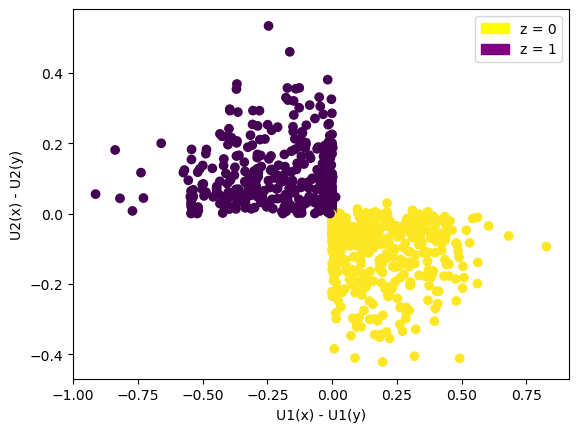

In [ ]:
# As an example here are the results obtained with:
""" # Uncomment the code to check your results
plt.figure()
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")
plt.show()
"""
# Here is how it should look like
from IPython.display import Image
Image("../images/MIP_results_example.png")

Your second assignement will be to find another model that will work well with larger data instances.